In [16]:
"""
Portfolio Returns Calculation Engine — Google Colab Notebook
============================================================
Convert this .py to .ipynb by opening in Colab or using jupytext.
Each `# %%` marker denotes a new cell.

Author: Josh (generated with Claude)
"""

'\nPortfolio Returns Calculation Engine — Google Colab Notebook\n============================================================\nConvert this .py to .ipynb by opening in Colab or using jupytext.\nEach `# %%` marker denotes a new cell.\n\nAuthor: Josh (generated with Claude)\n'

# Portfolio Returns Calculation Engine (MVP)

## Assumptions & Design Decisions

1. **`TRADINGITEMSTATUSID` Handling**
   - If the column exists in the dataset, we filter to rows where `TRADINGITEMSTATUSID == 15`
     (the "Active" status seen in sample data). This removes stale/delisted price rows.
   - If the column is absent, we use all rows (no filter) and log a warning.

2. **Date-Shifting Rule**
   - **Start date**: If the requested `start_date` is not a trading day for a given ticker,
     we use the *first available trading date on or after* `start_date`.
   - **End date**: If the requested `end_date` is not a trading day for a given ticker,
     we use the *last available trading date on or before* `end_date`.
   - If no valid date can be found in the required direction, the ticker is **dropped with a
     warning** and the remaining weights are **renormalized** (Approach B from the spec).

3. **Dividends / Splits**: Not implemented in this MVP. Returns are purely price-based.

4. **Duplicate Tickers**: If a ticker appears more than once in the input list, its weights
   are summed before calculation.

5. **Cash Residual**: When `allow_cash_residual=False` (default), we assume fractional shares
   are purchasable (common for ETFs on many platforms). When `True`, we floor the share count
   and keep leftover cash.

6. **Price Field**: Defaults to `PRICECLOSE`. User may specify `PRICEMID` instead.

## Cell 1 — Imports & Helper Functions

In [17]:
import pandas as pd
import numpy as np
from datetime import datetime
from typing import List, Optional, Dict, Tuple, Any
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# ──────────────────────────────────────────────────────────────
# HELPER: Validate & normalise weights
# ──────────────────────────────────────────────────────────────
def validate_weights(tickers: List[str], weights: List[float],
                     tolerance: float = 0.05) -> Tuple[List[str], List[float]]:
    """
    Validate and normalise portfolio weights.
    - Combines duplicate tickers by summing their weights.
    - If weights are within `tolerance` of 1.0, normalise them.
    - Otherwise raise ValueError.

    Returns de-duplicated (tickers, weights).
    """
    if len(tickers) != len(weights):
        raise ValueError(f"Length mismatch: {len(tickers)} tickers vs {len(weights)} weights.")
    if any(w < 0 for w in weights):
        raise ValueError("Negative weights are not allowed.")

    # Combine duplicate tickers
    combined: Dict[str, float] = {}
    for t, w in zip(tickers, weights):
        t_upper = t.strip().upper()
        combined[t_upper] = combined.get(t_upper, 0.0) + w

    tickers_out = list(combined.keys())
    weights_out = list(combined.values())
    total = sum(weights_out)

    if total == 0:
        raise ValueError("Total weight is zero.")
    if abs(total - 1.0) > tolerance:
        raise ValueError(
            f"Weights sum to {total:.4f}, which deviates from 1.0 by more than "
            f"tolerance ({tolerance}). Please fix your weights."
        )

    # Normalise
    weights_out = [w / total for w in weights_out]
    if abs(total - 1.0) > 1e-9:
        print(f"⚠️  Weights summed to {total:.6f}; normalised to 1.0.")
    return tickers_out, weights_out


# ──────────────────────────────────────────────────────────────
# HELPER: Prepare / clean the raw price DataFrame
# ──────────────────────────────────────────────────────────────
def prepare_price_data(df: pd.DataFrame, price_field: str = "PRICECLOSE") -> pd.DataFrame:
    """
    Clean and prepare the raw dataset.
    - Parse PRICEDATE as datetime.
    - Filter TRADINGITEMSTATUSID == 15 if column exists.
    - Sort by ticker + date.
    - Drop rows with null price_field.
    """
    df = df.copy()

    # Parse date
    df["PRICEDATE"] = pd.to_datetime(df["PRICEDATE"], errors="coerce")
    df = df.dropna(subset=["PRICEDATE"])

    # Filter on status if available
    if "TRADINGITEMSTATUSID" in df.columns:
        before = len(df)
        df = df[df["TRADINGITEMSTATUSID"].isin([1, 15])].copy()
        after = len(df)
        print(f"ℹ️  Filtered TRADINGITEMSTATUSID == 15: {before:,} → {after:,} rows.")
    else:
        print("⚠️  TRADINGITEMSTATUSID column not found — using all rows.")

    # Ensure price field exists and drop nulls
    if price_field not in df.columns:
        raise ValueError(f"Price field '{price_field}' not found in dataset columns: {list(df.columns)}")
    df[price_field] = pd.to_numeric(df[price_field], errors="coerce")
    df = df.dropna(subset=[price_field])

    # Uppercase tickers for consistent matching
    df["TICKERSYMBOL"] = df["TICKERSYMBOL"].astype(str).str.strip().str.upper()

    # Sort
    df = df.sort_values(["TICKERSYMBOL", "PRICEDATE"]).reset_index(drop=True)
    return df


# ──────────────────────────────────────────────────────────────
# HELPER: Get start/end price for a single ticker
# ──────────────────────────────────────────────────────────────
def get_ticker_prices(
    ticker_df: pd.DataFrame,
    ticker: str,
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
    price_field: str,
) -> Dict[str, Any]:
    """
    For a single ticker's sub-DataFrame, find:
      - start price on first trading day >= start_date
      - end price on last trading day <= end_date
    Returns dict with prices, dates used, and quality flags.
    """
    flags = []

    # --- Start date adjustment ---
    on_or_after = ticker_df[ticker_df["PRICEDATE"] >= start_date]
    if on_or_after.empty:
        return {"error": f"No trading data for {ticker} on or after {start_date.date()}."}
    start_row = on_or_after.iloc[0]
    start_date_used = start_row["PRICEDATE"]
    start_price = float(start_row[price_field])
    if start_date_used != start_date:
        flags.append(f"start shifted {start_date.date()}→{start_date_used.date()}")

    # --- End date adjustment ---
    on_or_before = ticker_df[ticker_df["PRICEDATE"] <= end_date]
    if on_or_before.empty:
        return {"error": f"No trading data for {ticker} on or before {end_date.date()}."}
    end_row = on_or_before.iloc[-1]
    end_date_used = end_row["PRICEDATE"]
    end_price = float(end_row[price_field])
    if end_date_used != end_date:
        flags.append(f"end shifted {end_date.date()}→{end_date_used.date()}")

    # Sanity: start must be before end
    if start_date_used > end_date_used:
        return {"error": f"Adjusted start ({start_date_used.date()}) is after adjusted end ({end_date_used.date()}) for {ticker}."}

    return {
        "start_date_used": start_date_used,
        "end_date_used": end_date_used,
        "start_price": start_price,
        "end_price": end_price,
        "flags": flags,
    }


# ──────────────────────────────────────────────────────────────
# MAIN ENGINE
# ──────────────────────────────────────────────────────────────
def calculate_portfolio_returns(
    df: pd.DataFrame,
    tickers: List[str],
    weights: List[float],
    start_date: str,
    end_date: str,
    initial_capital: float = 100_000.0,
    price_field: str = "PRICECLOSE",
    allow_cash_residual: bool = False,
) -> Tuple[Dict[str, Any], pd.DataFrame]:
    """
    Core portfolio-return calculation.

    Parameters
    ----------
    df : pd.DataFrame          Raw price dataset (will be cleaned internally).
    tickers : list[str]        Ticker symbols.
    weights : list[float]      Portfolio weights (must ≈ sum to 1).
    start_date, end_date : str Horizon bounds (YYYY-MM-DD).
    initial_capital : float    Starting investment.
    price_field : str          Column for prices ('PRICECLOSE' or 'PRICEMID').
    allow_cash_residual : bool If True, use whole shares and keep leftover cash.

    Returns
    -------
    summary : dict             Portfolio-level summary metrics.
    holdings : pd.DataFrame    Per-ticker detail.
    """

    # 0. Validate inputs
    if price_field not in ("PRICECLOSE", "PRICEMID"):
        raise ValueError(f"price_field must be 'PRICECLOSE' or 'PRICEMID', got '{price_field}'.")
    tickers, weights = validate_weights(tickers, weights)

    start_dt = pd.Timestamp(start_date)
    end_dt = pd.Timestamp(end_date)
    if start_dt >= end_dt:
        raise ValueError("start_date must be before end_date.")

    # 1. Prepare data
    clean = prepare_price_data(df, price_field)

    # 2. Check ticker existence
    available_tickers = set(clean["TICKERSYMBOL"].unique())
    missing = [t for t in tickers if t not in available_tickers]
    if missing:
        raise ValueError(f"Tickers not found in dataset: {missing}")

    # 3. Per-ticker price lookup
    rows = []
    dropped = []
    for ticker, weight in zip(tickers, weights):
        ticker_data = clean[clean["TICKERSYMBOL"] == ticker]
        result = get_ticker_prices(ticker_data, ticker, start_dt, end_dt, price_field)

        if "error" in result:
            warnings.warn(f"Dropping {ticker}: {result['error']}")
            dropped.append((ticker, weight, result["error"]))
            continue

        rows.append({
            "ticker": ticker,
            "weight": weight,
            **result,
        })

    # 4. Renormalise if any tickers were dropped
    if dropped and not rows:
        raise ValueError("All tickers were dropped due to insufficient data. Cannot compute returns.")
    if dropped:
        remaining_total = sum(r["weight"] for r in rows)
        for r in rows:
            r["weight"] = r["weight"] / remaining_total
        print(f"⚠️  Dropped {len(dropped)} ticker(s) and renormalised remaining weights.")
        for t, w, reason in dropped:
            print(f"    • {t} (weight {w:.4f}): {reason}")

    # 5. Calculate per-holding values
    holdings_data = []
    total_cash_residual = 0.0

    for r in rows:
        alloc = initial_capital * r["weight"]
        if allow_cash_residual:
            shares = int(alloc // r["start_price"])  # whole shares only
            cash_used = shares * r["start_price"]
            residual = alloc - cash_used
            total_cash_residual += residual
        else:
            shares = alloc / r["start_price"]  # fractional shares
            residual = 0.0

        end_value = shares * r["end_price"]
        price_return = (r["end_price"] / r["start_price"]) - 1.0
        unrealized_gain = end_value - (shares * r["start_price"])
        cost_basis = shares * r["start_price"]
        unrealized_gain_pct = unrealized_gain / cost_basis if cost_basis != 0 else 0.0

        # Quality flags
        flag_str = "; ".join(r["flags"]) if r["flags"] else "OK"

        holdings_data.append({
            "ticker": r["ticker"],
            "weight": r["weight"],
            "start_date_used": r["start_date_used"].strftime("%Y-%m-%d"),
            "end_date_used": r["end_date_used"].strftime("%Y-%m-%d"),
            "start_price": round(r["start_price"], 4),
            "end_price": round(r["end_price"], 4),
            "shares": round(shares, 6),
            "start_value": round(shares * r["start_price"], 2),
            "end_value": round(end_value, 2),
            "price_return": round(price_return, 6),
            "unrealized_gain_dollars": round(unrealized_gain, 2),
            "unrealized_gain_pct": round(unrealized_gain_pct, 6),
            "data_quality_flags": flag_str,
        })

    holdings_df = pd.DataFrame(holdings_data)

    # 6. Portfolio-level summary
    portfolio_end_value = holdings_df["end_value"].sum() + total_cash_residual
    cost_basis_total = holdings_df["start_value"].sum() + total_cash_residual
    total_unrealized = portfolio_end_value - initial_capital

    # Date range actually used (min start, max end across tickers)
    start_dates_used = pd.to_datetime(holdings_df["start_date_used"])
    end_dates_used = pd.to_datetime(holdings_df["end_date_used"])

    summary = {
        "portfolio_start_value": round(initial_capital, 2),
        "portfolio_end_value": round(portfolio_end_value, 2),
        "portfolio_total_return": round((portfolio_end_value / initial_capital) - 1, 6),
        "total_unrealized_gain_dollars": round(total_unrealized, 2),
        "total_unrealized_gain_pct": round(total_unrealized / initial_capital, 6),
        "cash_residual": round(total_cash_residual, 2) if allow_cash_residual else 0.0,
        "start_date_requested": str(start_date),
        "end_date_requested": str(end_date),
        "start_date_used_range": str(start_dates_used.min().date()),
        "end_date_used_range": str(end_dates_used.max().date()),
        "tickers_requested": len(tickers),
        "tickers_dropped": len(dropped),
        "price_field_used": price_field,
    }

    return summary, holdings_df

## Cell 2 — Load Dataset

Edit the path below to point to your actual CSV / Parquet file.
The variable `df` is the raw price DataFrame used by the engine.

In [18]:
# ── Option A: Load from CSV (edit path) ──
df = pd.read_csv("/content/price_data.csv")

# ── Option B: Load from Parquet ──
# df = pd.read_parquet("/content/your_price_data.parquet")

# ── Option C: If your data is already in a DataFrame (e.g. from a SQL query), ──
# ── just make sure it's named `df`.                                           ──

print(f"✅ Demo dataset loaded: {len(df):,} rows, tickers: {df['TICKERSYMBOL'].unique().tolist()}")

✅ Demo dataset loaded: 2,430,383 rows, tickers: ['AAAU', 'ABFL', 'ABLD', 'ABLG', 'ACWI', 'ACWV', 'AGG', 'AGGY', 'AGOX', 'AGZ', 'AIQ', 'ALAI', 'ANGL', 'APDY.X', 'ARB', 'ARTY', 'AVDE', 'AVEM', 'AVIG', 'AVLC', 'AVLV', 'AVUS', 'AVUV', 'BAI', 'BALI', 'BAUG', 'BBCB', 'BBIN', 'BBRE', 'BDHI.X', 'BDMI.X', 'BDVL', 'BDYN', 'BFRI.X', 'BHYI.X', 'BIDD', 'BILS', 'BIMB.X', 'BINC', 'BIV', 'BKGI', 'BKHY', 'BKLC', 'BKLN', 'BLV', 'BMCI.X', 'BND', 'BNDW', 'BNDX', 'BOND', 'BRHY', 'BRLN', 'BROI.X', 'BRTR', 'BSII.X', 'BSV', 'BTC', 'BUFF', 'BUG', 'BWX', 'CALF', 'CBHI.X', 'CEMB', 'CFO', 'CGBL', 'CGCP', 'CGDV', 'CGGR', 'CGIC', 'CGMS', 'CGMU', 'CGUS', 'CGXU', 'CIBR', 'CLOA', 'CLOU', 'CMDY', 'CMF', 'COMT', 'CORP', 'COWZ', 'CPAI', 'CRBN', 'CVIE', 'CWB', 'CWI', 'DBEF', 'DBJP', 'DEEF', 'DEM', 'DES', 'DFAC', 'DFAE', 'DFAI', 'DFAS', 'DFAT', 'DFAU', 'DFCF', 'DFGR', 'DFIP', 'DFIS', 'DFIV', 'DFLV', 'DFNM', 'DFSV', 'DFUS', 'DFUV', 'DGCB', 'DGRO', 'DGRS', 'DGRW', 'DGS', 'DHS', 'DIAL', 'DIVB', 'DIVI', 'DLN', 'DMXF', 'DNL', '

## Cell 3 — User Inputs & Run

In [19]:
# ═══════════════════════════════════════════════════
#  USER INPUTS — edit these values for your analysis
# ═══════════════════════════════════════════════════

TICKERS        = ["SPY", "AGG", "QQQ"]
WEIGHTS        = [0.50,  0.30,  0.20]
START_DATE     = "2023-06-01"
END_DATE       = "2024-06-01"
INITIAL_CAPITAL = 100_000
PRICE_FIELD    = "PRICECLOSE"      # or "PRICEMID"
ALLOW_CASH_RES = False             # True → whole shares + cash residual

# ═══════════════════════════════════════════════════

summary, holdings = calculate_portfolio_returns(
    df=df,
    tickers=TICKERS,
    weights=WEIGHTS,
    start_date=START_DATE,
    end_date=END_DATE,
    initial_capital=INITIAL_CAPITAL,
    price_field=PRICE_FIELD,
    allow_cash_residual=ALLOW_CASH_RES,
)

ℹ️  Filtered TRADINGITEMSTATUSID == 15: 2,430,383 → 2,430,383 rows.


## Cell 4 — Display Results

In [20]:
print("=" * 60)
print("  PORTFOLIO SUMMARY")
print("=" * 60)
for k, v in summary.items():
    label = k.replace("_", " ").title()
    if isinstance(v, float):
        if "pct" in k or "return" in k:
            print(f"  {label:.<40s} {v:>12.4%}")
        else:
            print(f"  {label:.<40s} ${v:>14,.2f}")
    else:
        print(f"  {label:.<40s} {v}")
print("=" * 60)

print("\n📊 Per-Holding Detail:\n")
display_cols = [
    "ticker", "weight", "start_price", "end_price",
    "shares", "start_value", "end_value",
    "price_return", "unrealized_gain_dollars", "data_quality_flags",
]
# In Colab, `display()` renders nicely; fallback to print
try:
    from IPython.display import display
    display(holdings[display_cols])
except ImportError:
    print(holdings[display_cols].to_string(index=False))

  PORTFOLIO SUMMARY
  Portfolio Start Value................... 100000
  Portfolio End Value..................... $    117,483.22
  Portfolio Total Return..................     17.4832%
  Total Unrealized Gain Dollars........... $     17,483.22
  Total Unrealized Gain Pct...............     17.4832%
  Cash Residual........................... $          0.00
  Start Date Requested.................... 2023-06-01
  End Date Requested...................... 2024-06-01
  Start Date Used Range................... 2023-06-01
  End Date Used Range..................... 2024-05-31
  Tickers Requested....................... 3
  Tickers Dropped......................... 0
  Price Field Used........................ PRICECLOSE

📊 Per-Holding Detail:



,ticker,weight,start_price,end_price,shares,start_value,end_value,price_return,unrealized_gain_dollars,data_quality_flags
0,SPY,0.5,421.82,527.37,118.533972,50000.0,62511.26,0.250225,12511.26,end shifted 2024-06-01→2024-05-31
1,AGG,0.3,98.61,96.52,304.228780,30000.0,29364.16,-0.021195,-635.84,end shifted 2024-06-01→2024-05-31
2,QQQ,0.2,352.01,450.71,56.816568,20000.0,25607.80,0.280390,5607.80,end shifted 2024-06-01→2024-05-31


## Cell 5 — Unit-Test-Style Assertions

In [21]:
print("Running assertions …\n")

# ─── Test 1: Weight normalisation ───────────────────────────
t1_tickers, t1_weights = validate_weights(["A", "B"], [0.6, 0.41])
assert abs(sum(t1_weights) - 1.0) < 1e-9, "Weights should be normalised to 1.0"
print("✅ Test 1 PASSED — weights normalised correctly.")

# Expect failure for wildly off weights
try:
    validate_weights(["A", "B"], [0.5, 0.1])
    assert False, "Should have raised ValueError"
except ValueError:
    print("✅ Test 2 PASSED — wildly off weights correctly rejected.")

# ─── Test 2: Missing ticker handling ────────────────────────
try:
    calculate_portfolio_returns(
        df=df,
        tickers=["SPY", "DOESNOTEXIST"],
        weights=[0.5, 0.5],
        start_date="2023-01-01",
        end_date="2024-01-01",
    )
    assert False, "Should have raised ValueError for missing ticker"
except ValueError as e:
    assert "DOESNOTEXIST" in str(e)
    print(f"✅ Test 3 PASSED — missing ticker caught: {e}")

# ─── Test 3: Date adjustment logic ─────────────────────────
# Pick a Saturday as start_date; engine should shift to Monday
sat_summary, sat_holdings = calculate_portfolio_returns(
    df=df,
    tickers=["SPY"],
    weights=[1.0],
    start_date="2023-01-07",  # Saturday
    end_date="2024-01-05",    # Friday
)
used_start = sat_holdings.iloc[0]["start_date_used"]
assert used_start >= "2023-01-07", "Start date should be shifted forward"
assert "shifted" in sat_holdings.iloc[0]["data_quality_flags"].lower() or used_start == "2023-01-09", \
    "Flag should note the shift or land on Monday 2023-01-09"
print(f"✅ Test 4 PASSED — start date shifted to {used_start} (requested Saturday 2023-01-07).")

# ─── Test 4: Duplicate ticker handling ──────────────────────
t4_tickers, t4_weights = validate_weights(["SPY", "AGG", "SPY"], [0.3, 0.3, 0.4])
assert "SPY" in t4_tickers and len(t4_tickers) == 2, "Duplicates should be merged"
spy_w = t4_weights[t4_tickers.index("SPY")]
assert abs(spy_w - 0.7) < 1e-9, f"SPY weight should be 0.7, got {spy_w}"
print("✅ Test 5 PASSED — duplicate tickers merged (SPY weight = 0.7).")

print("\n🎉 All assertions passed.")

Running assertions …

⚠️  Weights summed to 1.010000; normalised to 1.0.
✅ Test 1 PASSED — weights normalised correctly.
✅ Test 2 PASSED — wildly off weights correctly rejected.
ℹ️  Filtered TRADINGITEMSTATUSID == 15: 2,430,383 → 2,430,383 rows.
✅ Test 3 PASSED — missing ticker caught: Tickers not found in dataset: ['DOESNOTEXIST']
ℹ️  Filtered TRADINGITEMSTATUSID == 15: 2,430,383 → 2,430,383 rows.
✅ Test 4 PASSED — start date shifted to 2023-01-09 (requested Saturday 2023-01-07).
✅ Test 5 PASSED — duplicate tickers merged (SPY weight = 0.7).

🎉 All assertions passed.


In [22]:
def build_daily_portfolio_series(
    df: pd.DataFrame,
    holdings: pd.DataFrame,
    initial_capital: float,
    price_field: str = "PRICECLOSE",
) -> pd.DataFrame:
    """
    Reconstruct daily portfolio value from raw price data + holdings table.

    Returns a DataFrame indexed by date with columns:
      - one column per ticker (daily value of that holding)
      - 'portfolio_value'  (sum across tickers)
      - 'cost_basis'       (flat line = initial_capital)
    """
    clean = df.copy()
    clean["PRICEDATE"] = pd.to_datetime(clean["PRICEDATE"], errors="coerce")
    clean["TICKERSYMBOL"] = clean["TICKERSYMBOL"].astype(str).str.strip().str.upper()
    clean[price_field] = pd.to_numeric(clean[price_field], errors="coerce")

    # Filter to the date window that the engine actually used
    all_start = pd.to_datetime(holdings["start_date_used"]).min()
    all_end = pd.to_datetime(holdings["end_date_used"]).max()
    clean = clean[(clean["PRICEDATE"] >= all_start) & (clean["PRICEDATE"] <= all_end)]

    # Build a per-ticker daily value series
    ticker_frames = []
    for _, row in holdings.iterrows():
        tk = row["ticker"]
        shares = row["shares"]
        tk_prices = (
            clean[clean["TICKERSYMBOL"] == tk][["PRICEDATE", price_field]]
            .drop_duplicates(subset="PRICEDATE")
            .set_index("PRICEDATE")
            .sort_index()
            .rename(columns={price_field: tk})
        )
        tk_prices[tk] = tk_prices[tk] * shares  # daily market value
        ticker_frames.append(tk_prices)

    # Merge on date (outer join keeps all trading days, forward-fill gaps)
    daily = ticker_frames[0]
    for tf in ticker_frames[1:]:
        daily = daily.join(tf, how="outer")
    daily = daily.sort_index().ffill().bfill()

    daily["portfolio_value"] = daily[holdings["ticker"].tolist()].sum(axis=1)
    daily["cost_basis"] = initial_capital
    return daily

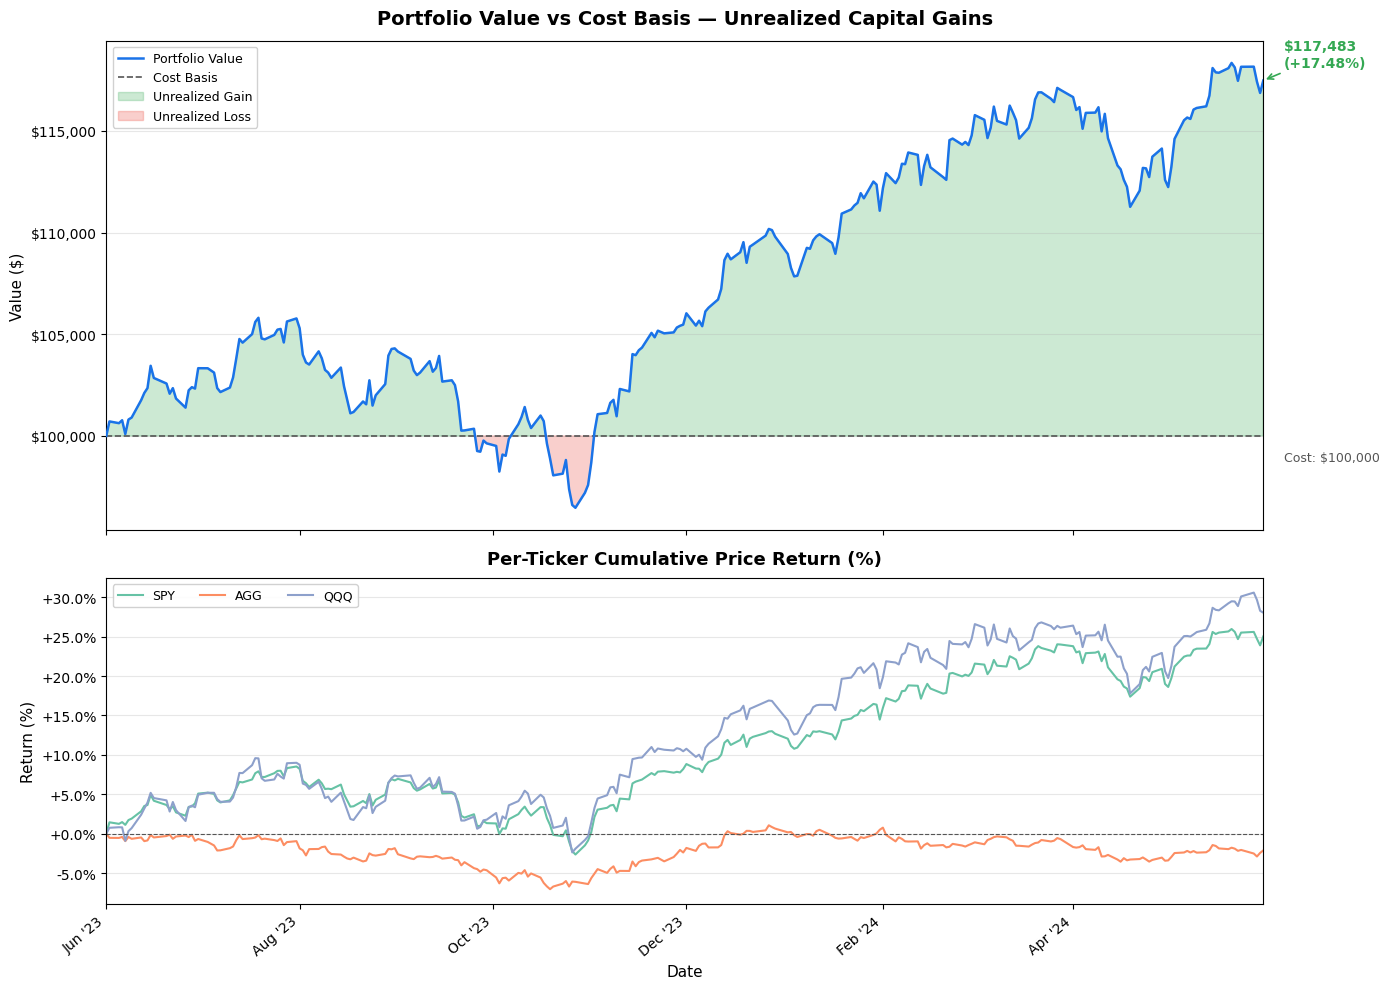

📈 Charts saved to portfolio_visualization.png
Running assertions …

⚠️  Weights summed to 1.010000; normalised to 1.0.
✅ Test 1 PASSED — weights normalised correctly.
✅ Test 2 PASSED — wildly off weights correctly rejected.
ℹ️  Filtered TRADINGITEMSTATUSID == 15: 2,430,383 → 2,430,383 rows.
✅ Test 3 PASSED — missing ticker caught: Tickers not found in dataset: ['DOESNOTEXIST']


In [23]:
def plot_portfolio_visualizations(
    df: pd.DataFrame,
    holdings: pd.DataFrame,
    summary: dict,
    initial_capital: float,
    price_field: str = "PRICECLOSE",
):
    """
    Render two charts:
      (1) Portfolio value vs cost basis with shaded unrealized gain/loss.
      (2) Per-ticker cumulative return lines.
    """
    daily = build_daily_portfolio_series(df, holdings, initial_capital, price_field)
    tickers = holdings["ticker"].tolist()

    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                             gridspec_kw={"height_ratios": [3, 2]})

    # ── Chart 1: Portfolio Value vs Cost Basis ──────────────
    ax1 = axes[0]
    dates = daily.index
    pv = daily["portfolio_value"]
    cb = daily["cost_basis"]

    ax1.plot(dates, pv, color="#1a73e8", linewidth=1.8, label="Portfolio Value", zorder=3)
    ax1.axhline(y=initial_capital, color="#555555", linewidth=1.2,
                linestyle="--", label="Cost Basis", zorder=2)

    # Shade: green where value > cost, red where value < cost
    ax1.fill_between(
        dates, pv, cb,
        where=(pv >= cb),
        interpolate=True,
        color="#34a853", alpha=0.25,
        label="Unrealized Gain",
        zorder=1,
    )
    ax1.fill_between(
        dates, pv, cb,
        where=(pv < cb),
        interpolate=True,
        color="#ea4335", alpha=0.25,
        label="Unrealized Loss",
        zorder=1,
    )

    # Annotate final values
    final_val = pv.iloc[-1]
    gain_dollar = final_val - initial_capital
    gain_pct = gain_dollar / initial_capital
    gain_color = "#34a853" if gain_dollar >= 0 else "#ea4335"
    ax1.annotate(
        f"${final_val:,.0f}\n({gain_pct:+.2%})",
        xy=(dates[-1], final_val),
        xytext=(15, 10), textcoords="offset points",
        fontsize=10, fontweight="bold", color=gain_color,
        arrowprops=dict(arrowstyle="->", color=gain_color, lw=1.2),
    )
    ax1.annotate(
        f"Cost: ${initial_capital:,.0f}",
        xy=(dates[-1], initial_capital),
        xytext=(15, -18), textcoords="offset points",
        fontsize=9, color="#555555",
    )

    ax1.set_title("Portfolio Value vs Cost Basis — Unrealized Capital Gains",
                   fontsize=14, fontweight="bold", pad=12)
    ax1.set_ylabel("Value ($)", fontsize=11)
    ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))
    ax1.legend(loc="upper left", fontsize=9, framealpha=0.9)
    ax1.grid(axis="y", alpha=0.3)
    ax1.set_xlim(dates[0], dates[-1])

    # ── Chart 2: Per-Ticker Cumulative Returns ─────────────
    ax2 = axes[1]
    colors = plt.cm.Set2.colors  # nice qualitative palette

    for i, tk in enumerate(tickers):
        tk_vals = daily[tk]
        start_val = tk_vals.iloc[0]
        cum_return = (tk_vals / start_val - 1) * 100  # in percent
        ax2.plot(dates, cum_return, linewidth=1.5,
                 color=colors[i % len(colors)], label=tk)

    ax2.axhline(y=0, color="#555555", linewidth=0.8, linestyle="--")
    ax2.set_title("Per-Ticker Cumulative Price Return (%)", fontsize=13,
                   fontweight="bold", pad=10)
    ax2.set_ylabel("Return (%)", fontsize=11)
    ax2.set_xlabel("Date", fontsize=11)
    ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:+.1f}%"))
    ax2.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=len(tickers))
    ax2.grid(axis="y", alpha=0.3)

    # Shared x-axis formatting
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=40, ha="right")

    fig.tight_layout()
    plt.savefig("portfolio_visualization.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("📈 Charts saved to portfolio_visualization.png")


# Run the visualization
plot_portfolio_visualizations(
    df=df,
    holdings=holdings,
    summary=summary,
    initial_capital=INITIAL_CAPITAL,
    price_field=PRICE_FIELD,
)